In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.distributions import *
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
from torchdeepretina.pyret_func import estfr

In [155]:
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
t_list = [3,3,3,3,2,3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

optimum_para = {}
optimum_para['gaussian'] = [0.61, 0.56, 0.56, 0.58, 1., 1.22]
optimum_para['poisson1'] = [5.56, 8.87, 4.65, 3.80, 1., 0.83]
optimum_para['poisson2'] = [3.81, 5.03, 3.30, 2.92, 6.10, 0.61]
optimum_para['binomial'] = [2.17, 2.85, 1.91, 1.69, 1., 0.47]

In [4]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

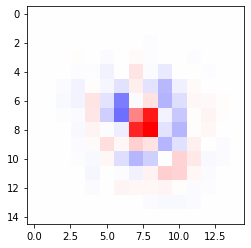

In [25]:
import pyret
from kinetic.utils import LinearStack
state_dict = checkpoint['model_state_dict']
conv_weights = []
for i in range((cfg.Model.ksizes[0]-1)//2):
    conv_weights.append(state_dict['bipolar.0.convs.{}.weight'.format(i)].cpu().numpy())
#kernel = LinearStack(conv_weights)[0, 10]
kernel = pyret.filtertools.decompose(LinearStack(conv_weights)[5])[0]
plt.imshow(kernel, cmap='bwr', vmin=-np.abs(kernel).max(), vmax=np.abs(kernel).max())

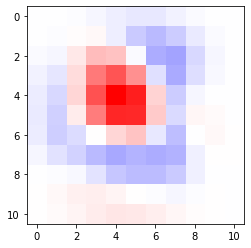

In [38]:
state_dict = checkpoint['model_state_dict']
conv_weights = []
for i in range((cfg.Model.ksizes[1]-1)//2):
    conv_weights.append(state_dict['amacrine.1.convs.{}.weight'.format(i)].cpu().numpy())
kernel = pyret.filtertools.decompose(LinearStack(conv_weights)[7])[0]
plt.imshow(kernel, cmap='bwr', vmin=-np.abs(kernel).max(), vmax=np.abs(kernel).max())

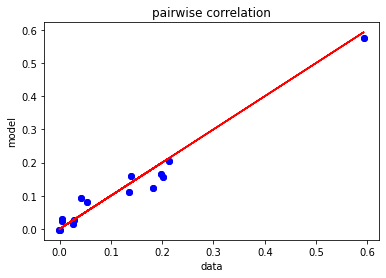

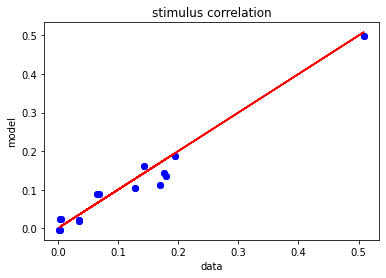

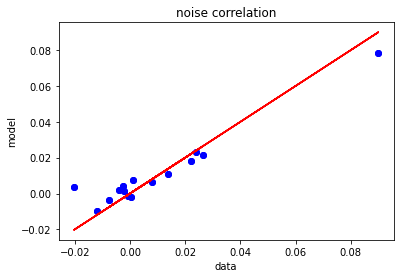

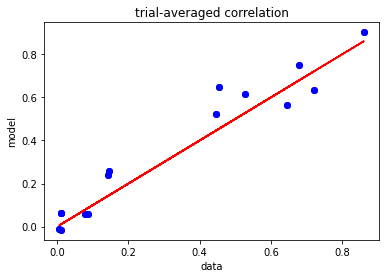

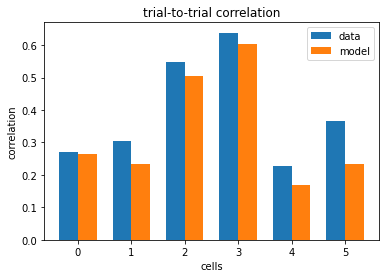

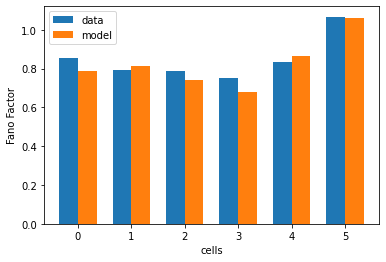

In [39]:
binomial_para = [2.17, 2.85, 2.3, 2.3, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.55, 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=27, thre=10)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)

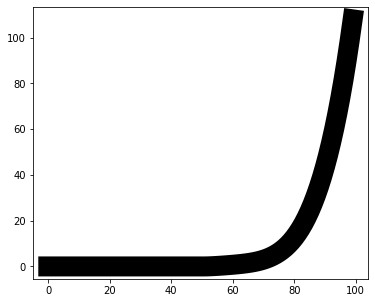

In [62]:
plt.figure(figsize=(6,5))
x = np.linspace(-2, 2, 100)
x[x<0] = 0
a,b,c,d,_ = poly_paras[3]
y = a*x**4+b*x**3+c*x**2+d*x
plt.plot(y, color='black', linewidth=20)

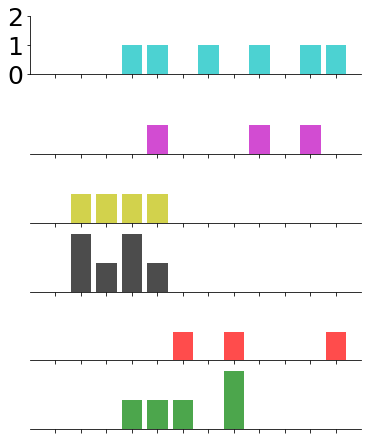

In [128]:
colors = ['c', 'm', 'y', 'k', 'r', 'g']
fig, axes = plt.subplots(6,1, figsize=(5, 6), sharex=True, constrained_layout=True)
for cell in range(6):
    axes[cell].bar(np.arange(1168,1180), single_trial_bin[0,1168:1180,cell], color=colors[cell], alpha=0.7)
    axes[cell].set_ylim([0,2])
    axes[cell].xaxis.set_ticks(np.arange(1168,1180))
    axes[cell].spines['right'].set_visible(False)
    axes[cell].spines['top'].set_visible(False)
    axes[cell].tick_params(axis='x', labelbottom=False)
    if cell == 0:
        axes[cell].yaxis.set_ticks([0,1,2])
        axes[cell].tick_params(axis='y', labelsize=25)
        continue
    axes[cell].spines['left'].set_visible(False)
    axes[cell].tick_params(axis='y', left=False, labelleft=False)
plt.show()

In [150]:
dist = distribution(5)
for cell in range(6):
    optim_k = dist.optimize_k('second_norm', single_trial_bin, cell, 0.2, 1.5)
    print(cell, dist.KL('second_norm', optim_k, recording, cell))

0 0.0637153845222761
1 0.08067855469590485
2 0.06673183823007811
3 0.09488594040968178
4 0.09688712306228817
5 0.3362610462323396


In [156]:
stats = variance_mean(recording, t_list, optimum_para)

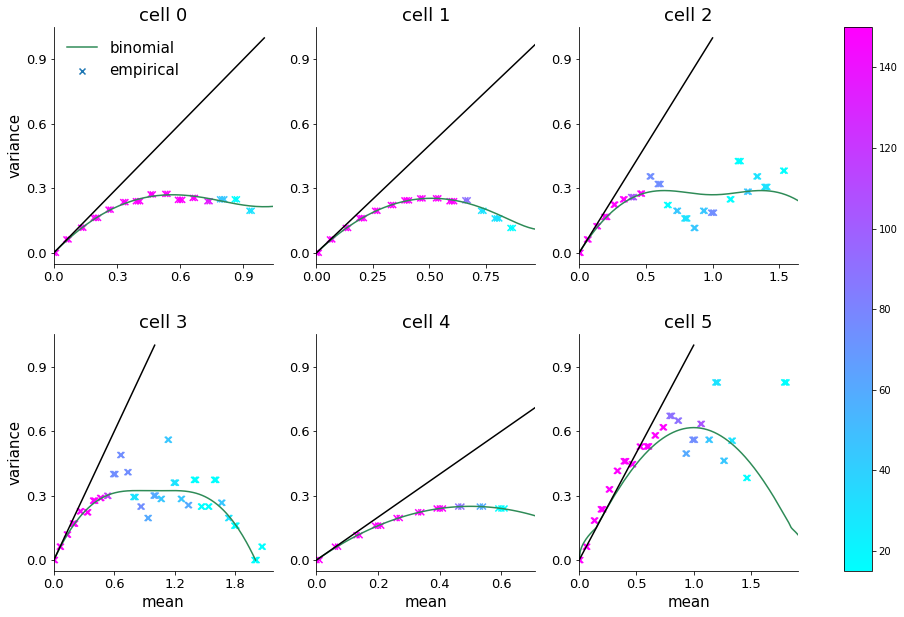

In [227]:
variance_mean_plot(stats, save='var_mean')

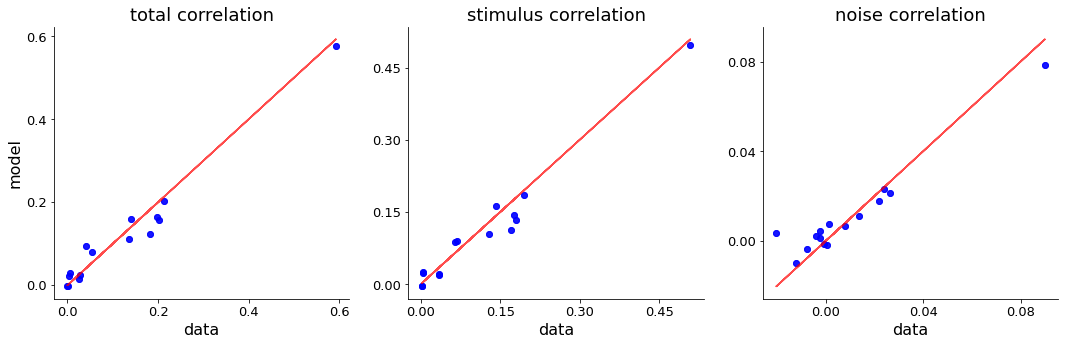

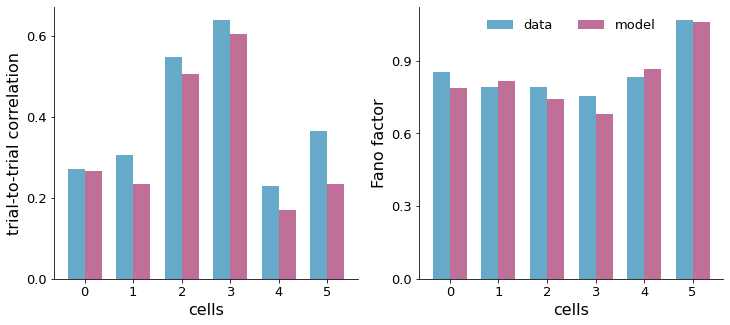

In [215]:
second_stats_plot(single_trial_bin, pred_single_trial_try, save=['corr','var'])

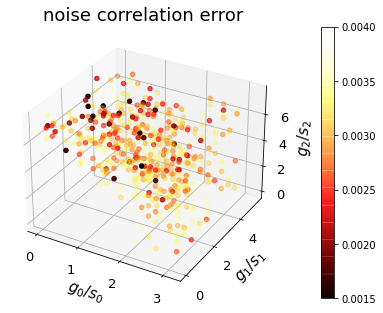

In [226]:
cmap = pl.cm.hot
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(1, 0, cmap.N)
my_cmap = ListedColormap(my_cmap)

g0s = []
g1s = []
g2s = []
errors =[]
f = open('./errors3.txt', 'r')
for line in f.readlines():
    g0 = round(float(line.split()[0][1:-1]), 3)
    g1 = round(float(line.split()[1][:-1]), 3)
    g2 = round(float(line.split()[2][:-1]), 3)
    error = float(line.split()[3])
    g0s.append(g0)
    g1s.append(g1)
    g2s.append(g2)
    errors.append(error)
g0s = np.array(g0s)/0.759
g1s = np.array(g1s)/0.0759
g2s = np.array(g2s)/0.0870
errors = np.array(errors)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(g0s, g1s, g2s, c=errors, marker='o', cmap=my_cmap, vmax=0.004, vmin=0.0015, depthshade=False)
ax.set_xlabel(r'$g_0/s_0$', fontsize=15)
ax.set_ylabel(r'$g_1/s_1$', fontsize=15)
ax.set_zlabel(r'$g_2/s_2$', fontsize=15)
ax.set_title('noise correlation error', fontsize=18)
fig.colorbar(p, ax=ax)
plt.locator_params(nbins=5)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.savefig('/home/xhding/workspaces/torch-deep-retina/fnn/notebook/figs/3d.png', dpi=300, bbox_inches = "tight")
plt.show()